### Assignment 4: Deep Learning

Deep Learning is a subfield of machine learning concerned with algorithms inspired by the structure and function of the brain called artificial neural networks.

### Recurrent neural network (RNN) on Keras:
The most commonly used neural network for predicting time series data is Recurrent neural network (RNN) on Keras.

The recurrent neural network (RNN) is a type of artificial neural network with self-loop in its hidden layer(s), which enables RNN to use the previous state of the hidden neuron(s) to learn the current state given the new input. RNN is good at processing sequential data. Long short-term memory (LSTM) cell is a specially designed working unit that helps RNN better memorize the long-term context.

In [ ]:
!pip install keras

You are using pip version 9.0.1, however version 10.0.0 is available.
You should consider upgrading via the 'python -m pip install --upgrade pip' command.


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas import datetime
import math, time
import itertools
from sklearn import preprocessing
import datetime
from operator import itemgetter
from sklearn.metrics import mean_squared_error
from math import sqrt
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.layers.recurrent import LSTM
from keras.models import load_model
import keras
import h5py
import requests
import os

Using TensorFlow backend.


In [ ]:
#read csv
df = pd.read_csv('prices-split-adjusted (1).csv',index_col=0)

In [3]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [4]:
df['adj close'] = df['close']
df.drop(['close'], 1, inplace=True)
df.head()

,symbol,open,low,high,volume,adj close
date,,,,,,
2016-01-05,WLTW,123.430000,122.309998,126.250000,2163600.0,125.839996
2016-01-06,WLTW,125.239998,119.940002,125.540001,2386400.0,119.980003
2016-01-07,WLTW,116.379997,114.930000,119.739998,2489500.0,114.949997
2016-01-08,WLTW,115.480003,113.500000,117.440002,2006300.0,116.620003
2016-01-11,WLTW,117.010002,114.089996,117.330002,1408600.0,114.970001


### Analyze stock data for Apple(AAPL):

In [5]:
df = df[df.symbol == 'AAPL']
df.drop(['symbol'],1,inplace=True)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,30.490000,30.340000,30.642857,123432400.0,30.572857
2010-01-05,30.657143,30.464285,30.798571,150476200.0,30.625713
2010-01-06,30.625713,30.107143,30.747143,138040000.0,30.138571
2010-01-07,30.250000,29.864286,30.285715,119282800.0,30.082857
2010-01-08,30.042856,29.865715,30.285715,111902700.0,30.282858


### Normalize data:

In [6]:
def normalize_data(df):
    min_max_scaler = preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['volume'] = min_max_scaler.fit_transform(df.volume.values.reshape(-1,1))
    df['adj close'] = min_max_scaler.fit_transform(df['adj close'].values.reshape(-1,1))
    return df
df = normalize_data(df)
df.head()

,open,low,high,volume,adj close
date,,,,,
2010-01-04,0.028123,0.030334,0.024806,0.244034,0.029718
2010-01-05,0.029686,0.031526,0.026268,0.302982,0.030219
2010-01-06,0.029392,0.028100,0.025785,0.275875,0.025604
2010-01-07,0.025880,0.025769,0.021454,0.234989,0.025076
2010-01-08,0.023943,0.025783,0.021454,0.218903,0.026971


In [7]:
def load_data(stock, seq_len):
    amount_of_features = len(stock.columns) # 5
    data = stock.as_matrix() 
    sequence_length = seq_len + 1 # index starting from 0
    result = []
    
    for index in range(len(data) - sequence_length): # maxmimum date = lastest date - sequence length
        result.append(data[index: index + sequence_length]) # index : index + 22days
    
    result = np.array(result)
    row = round(0.9 * result.shape[0]) # 90% split
    train = result[:int(row), :] # 90% date, all features 
    
    x_train = train[:, :-1] 
    y_train = train[:, -1][:,-1]
    
    x_test = result[int(row):, :-1] 
    y_test = result[int(row):, -1][:,-1]

    x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], amount_of_features))
    x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], amount_of_features))  

    return [x_train, y_train, x_test, y_test]

### Build model:

In [8]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

### Fit test and train data:

In [9]:
window = 20
X_train, y_train, X_test, y_test = load_data(df, window)
print (X_train[0], y_train[0])

[[  2.81231215e-02   3.03337678e-02   2.48062394e-02   2.44034312e-01
    2.97178362e-02]
 [  2.96855171e-02   3.15262743e-02   2.62677938e-02   3.02982342e-01
    3.02185399e-02]
 [  2.93917266e-02   2.80995178e-02   2.57850858e-02   2.75874854e-01
    2.56038867e-02]
 [  2.58796844e-02   2.57693155e-02   2.14540576e-02   2.34989328e-01
    2.50761176e-02]
 [  2.39433742e-02   2.57830226e-02   2.14540576e-02   2.18902744e-01
    2.69707045e-02]
 [  2.72818302e-02   2.49468907e-02   2.27949303e-02   2.26868983e-01
    2.44400840e-02]
 [  2.24611028e-02   2.21643437e-02   1.84638847e-02   2.98925222e-01
    2.12057623e-02]
 [  2.06984135e-02   1.89843011e-02   2.00193033e-02   3.05155092e-01
    2.51708493e-02]
 [  2.36896638e-02   2.57281929e-02   1.93890932e-02   2.10883102e-01
    2.35198553e-02]
 [  2.47846654e-02   2.14104557e-02   2.09176943e-02   2.98711609e-01
    1.87834049e-02]
 [  2.13126846e-02   2.32883326e-02   2.57314493e-02   3.72789542e-01
    3.11117019e-02]
 [  3.0099

In [10]:
model = build_model([5,window,1])

Compilation Time :  0.03902840614318848


### Fit model with 90 epochs:

In [11]:
model.fit(X_train,y_train,batch_size=512,epochs=90,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/90
1410/1410 [==============================] - 7s 5ms/step - loss: 0.2445 - acc: 7.0922e-04 - val_loss: 0.4383 - val_acc: 0.0000e+00
Epoch 2/90
1410/1410 [==============================] - 5s 4ms/step - loss: 0.1318 - acc: 7.0922e-04 - val_loss: 0.0478 - val_acc: 0.0000e+00
Epoch 3/90
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0632 - acc: 0.0014 - val_loss: 0.0183 - val_acc: 0.0000e+00
Epoch 4/90
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0504 - acc: 0.0014 - val_loss: 0.0968 - val_acc: 0.0000e+00
Epoch 5/90
1410/1410 [==============================] - 5s 3ms/step - loss: 0.0430 - acc: 7.0922e-04 - val_loss: 0.1248 - val_acc: 0.0000e+00
Epoch 6/90
1410/1410 [==============================] - 5s 3ms/step - loss: 0.0390 - acc: 7.0922e-04 - val_loss: 0.0553 - val_acc: 0.0000e+00
Epoch 7/90
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0184 - acc: 0.0014 - val_loss: 

In [12]:
diff=[]
ratio=[]
p = model.predict(X_test)
print (p.shape) #for each data index in test data
for u in range(len(y_test)):
    # pr = prediction day u
    pr = p[u][0]
    # (y_test day u / pr) - 1
    ratio.append((y_test[u]/pr)-1)
    diff.append(abs(y_test[u]- pr))

(174, 1)


### RMSE score:

In [13]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00067 MSE (0.03 RMSE)
Test Score: 0.00117 MSE (0.03 RMSE)


(0.00066958577308985667, 0.0011673327535390854)

In [14]:
df = pd.read_csv('prices-split-adjusted.csv', index_col = 0)
df["adj close"] = df.close # Moving close to the last column
df.drop(['close'], 1, inplace=True) # Moving close to the last column
df = df[df.symbol == 'AAPL']
df.drop(['symbol'],1,inplace=True)

# Bug fixed at here, please update the denormalize function to this one
def denormalize(df, normalized_value): 
    df = df['adj close'].values.reshape(-1,1)
    normalized_value = normalized_value.reshape(-1,1)
    
    #return df.shape, p.shape
    min_max_scaler = preprocessing.MinMaxScaler()
    a = min_max_scaler.fit_transform(df)
    new = min_max_scaler.inverse_transform(normalized_value)
    return new

newp = denormalize(df, p)
newy_test = denormalize(df, y_test)

In [15]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00067 MSE (0.03 RMSE)
Test Score: 0.00117 MSE (0.03 RMSE)


(0.00066958577308985667, 0.0011673327535390854)

### Plotting: Prediction vs Actual:

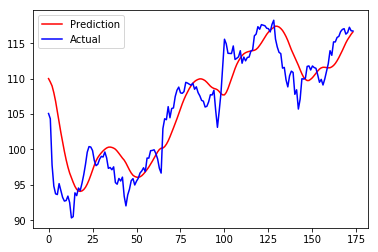

In [19]:
import matplotlib.pyplot as plt
plt.plot(newp,color='red', label='Prediction')
plt.plot(newy_test,color='blue', label='Actual')
plt.legend(loc='best')
plt.show()

#### The predicted value is very close to actual value and hence, the prediction model of RNN using Keras works pretty good.

### Part B - Activation Function:
 Change the activation function. How does it effect the accuracy?
 
 LeakyReLU and PReLU are slightly better versions of ReLU activation function and we should expect slightly higher accuracy.
### 1. Using LeakyReLU as activation function:

In [22]:
from keras.layers.advanced_activations import LeakyReLU, PReLU

In [23]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    #model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    model.add(LeakyReLU(alpha=.1)) 
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [24]:
model = build_model([5,window,1])

Compilation Time :  0.030521631240844727


In [25]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 8s 6ms/step - loss: 0.1607 - acc: 7.0922e-04 - val_loss: 0.0196 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0228 - acc: 0.0014 - val_loss: 0.0292 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0217 - acc: 0.0014 - val_loss: 0.0432 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0102 - acc: 0.0014 - val_loss: 0.0107 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0120 - acc: 0.0014 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0041 - acc: 0.0014 - val_loss: 0.0186 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0078 - acc: 0.0014 - val_loss: 0.0047 - val

In [26]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00074 MSE (0.03 RMSE)
Test Score: 0.00120 MSE (0.03 RMSE)


(0.00073867990914969954, 0.0011951407048337419)

### 2. Using PReLU as the activation function:

In [27]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    #model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    act = keras.layers.advanced_activations.PReLU(init='one', weights=None)
    model.add(act) 
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [28]:
model = build_model([5,window,1])

Compilation Time :  0.030521154403686523


C:\Users\user\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Update your `PReLU` call to the Keras 2 API: `PReLU(weights=None, alpha_initializer="one")`
  del sys.path[0]


In [29]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 8s 5ms/step - loss: 0.1596 - acc: 7.0922e-04 - val_loss: 0.0254 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0208 - acc: 0.0014 - val_loss: 0.0251 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0179 - acc: 0.0014 - val_loss: 0.0334 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0081 - acc: 0.0014 - val_loss: 0.0122 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0109 - acc: 0.0014 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0044 - acc: 0.0014 - val_loss: 0.0174 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0069 - acc: 0.0014 - val_loss: 0.0023 - val

In [30]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00077 MSE (0.03 RMSE)
Test Score: 0.00120 MSE (0.03 RMSE)


(0.00077128704074454029, 0.0011958439323258982)

### Results:
Applying LeakyReLU and PReLU as activation function, we get a little better accuracy for test case. However, it doesnt change much.

### Part C - Cost Function:
A cost function is a measure of "how good" a neural network did with respect to it's given training sample and the expected output. It also may depend on variables such as weights and biases.

### 1. Using hinge:

In [39]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    #model.add(LeakyReLU(alpha=.1)) 
        
    start = time.time()
    model.compile(loss='hinge',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [40]:
model = build_model([5,window,1])

Compilation Time :  0.039559364318847656


In [41]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 10s 7ms/step - loss: 0.9287 - acc: 7.0922e-04 - val_loss: 0.2306 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.4918 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.1211 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0600 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0498 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0448 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.04

In [42]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.01754 MSE (0.13 RMSE)
Test Score: 0.00000 MSE (0.00 RMSE)


(0.017535012964237703, 0.0)

### 2. Using Squared hinge:

In [47]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
        
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    #model.add(LeakyReLU(alpha=.1)) 
        
    start = time.time()
    model.compile(loss='squared_hinge',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [48]:
model = build_model([5,window,1])

Compilation Time :  0.03202319145202637


In [49]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 8s 6ms/step - loss: 0.9882 - acc: 7.0922e-04 - val_loss: 0.8728 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.8755 - acc: 7.0922e-04 - val_loss: 0.3401 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.5326 - acc: 0.0014 - val_loss: 0.0175 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.2724 - acc: 7.0922e-04 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.1560 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.1104 - acc: 0.0000e+00 - val_loss: 0.0000e+00 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0837 - acc: 0.0

In [50]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.02002 MSE (0.14 RMSE)
Test Score: 0.00000 MSE (0.00 RMSE)


(0.020022971354705481, 0.0)

### Result:
Using both hinge and squared hinge as the cost function, the test case accuracy is the best.

### Part D - Epochs:
An epoch is the entire training data exposed to the network, batch-by-batch. As no. of epoch increases, one would expect the test accuracy to increase. However, avoid overfitting the model.

Change the number of epochs initialization. How does it effect the accuracy?

### 1. Epoch = 50

In [31]:
model.fit(X_train,y_train,batch_size=512,epochs=50,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/50
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 2/50
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 3/50
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 4/50
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0016 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 5/50
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 6/50
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 7/50
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0011 - val_acc

In [32]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]
model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00065 MSE (0.03 RMSE)
Test Score: 0.00099 MSE (0.03 RMSE)


(0.00065125050584844476, 0.00099131149566336271)

### 2. Epoch =20

In [15]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0015 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0015 - acc: 0.0014 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 3ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0019 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0017 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0014 - acc: 0.0014 - val_loss: 0.0015 - val_acc

In [16]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]


model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00075 MSE (0.03 RMSE)
Test Score: 0.00137 MSE (0.04 RMSE)


(0.00075324305526207336, 0.0013732683982689404)

### Result:
As the number of epoch increases, the test accuracy also increases.

### Part E - Gradient estimation:
Change the gradient estimation. How does it effect the accuracy?

### 1. Using RMSDrop:

In [29]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
                
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    start = time.time()
    model.compile(loss='mse',optimizer='RMSProp', metrics=['accuracy'])
    keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    print("Compilation Time : ", time.time() - start)
    return model

In [30]:
model = build_model([5,window,1])

Compilation Time :  0.043030500411987305


In [31]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 8s 6ms/step - loss: 0.1801 - acc: 0.0014 - val_loss: 0.3921 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0853 - acc: 7.0922e-04 - val_loss: 0.2800 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0603 - acc: 7.0922e-04 - val_loss: 0.0664 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0290 - acc: 0.0014 - val_loss: 0.0047 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0288 - acc: 0.0014 - val_loss: 0.0321 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0139 - acc: 0.0014 - val_loss: 0.0108 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0226 - acc: 0.0014 - val_loss: 0.0353 -

In [32]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00749 MSE (0.09 RMSE)
Test Score: 0.01334 MSE (0.12 RMSE)


(0.0074913287582856576, 0.013338576437605694)

### 2. Using Stochiotic Gradient Descent(SGD):

In [33]:
def build_model(layers):
    d = 0.3
    model = Sequential()
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
                
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
    
    start = time.time()
    model.compile(loss='mse',optimizer='SGD', metrics=['accuracy'])
    keras.optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)
    print("Compilation Time : ", time.time() - start)
    return model

In [34]:
model = build_model([5,window,1])

Compilation Time :  0.04102730751037598


In [35]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 8s 5ms/step - loss: 0.2509 - acc: 7.0922e-04 - val_loss: 0.5484 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.2294 - acc: 7.0922e-04 - val_loss: 0.5125 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.2105 - acc: 7.0922e-04 - val_loss: 0.4801 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.1938 - acc: 7.0922e-04 - val_loss: 0.4504 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.1789 - acc: 7.0922e-04 - val_loss: 0.4233 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.1657 - acc: 7.0922e-04 - val_loss: 0.3986 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.1541 - acc: 7.0922e-04 

In [36]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.09433 MSE (0.31 RMSE)
Test Score: 0.19051 MSE (0.44 RMSE)


(0.094333360255734508, 0.19051299047196049)

### Result:
The test accuracy decreases.
### RMSE:
#### For RMSDrop:
- Train = 0.007
- Test = 0.013

#### For SGD:
- Train =0.094
- Test = 0.19

### Result:

### Part F - Network Architecture:
Change the network architecture. How does it effect the accuracy?
How does it effect how quickly the network plateaus?
Various forms of network architecture:
- Number of layers
- Size of each layer

### 1. No. of layers:

In [48]:
def build_model(layers):
    d = 0.3 #Dropout
    #Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
    
    model = Sequential()
    
    #hidden layer
    #model.add(LSTM(hidden_nodes, input_shape=(timesteps, input_dim)))
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    model.add(LSTM(256, input_shape=(layers[1], layers[0]), return_sequences=False))
    model.add(Dropout(d))
     
    #output layer    
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [16]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0012 - acc: 0.0014 - val_loss: 0.0021 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0016 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0016 - acc: 0.0014 - val_loss: 0.0018 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0013 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0012 - acc: 0.0014 - val_loss: 0.0011 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0012 - acc: 0.0014 - val_loss: 0.0016 - val_acc

In [17]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00069 MSE (0.03 RMSE)
Test Score: 0.00134 MSE (0.04 RMSE)


(0.00068764324592255255, 0.0013435743640420488)

### 2. Size of the layer:

In [21]:
def build_model(layers):
    d = 0.3 #Dropout
    #Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
    
    model = Sequential()

    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
     
    #output layer    
    model.add(Dense(32,kernel_initializer="uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [22]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 0.0013 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 9.7355e-04 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 9.7961e-04 - acc: 0.0014 - val_loss: 8.7137e-04 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 0.0014 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 9.1163e-04 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0011 - acc: 0.0014 - val_loss: 

In [23]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00059 MSE (0.02 RMSE)
Test Score: 0.00098 MSE (0.03 RMSE)


(0.00058570810352661902, 0.00098301268526588452)

### Result:
The mse for test and train score decreases and hence accuracy increases slightly.

### Part G - Network initialization:
Change the network initialization. How does it effect the accuracy?

How does it effect how quickly the network plateaus?

### 1. Gaussian:

In [24]:
def build_model(layers):
    d = 0.3 #Dropout
    #Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
    
    model = Sequential()
    
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
     
    #output layer    
    model.add(Dense(32,kernel_initializer="gaussian",activation='relu'))        
    model.add(Dense(1,kernel_initializer="gaussian",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [ ]:
model = build_model([5,window,1])

In [25]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 5s 4ms/step - loss: 9.6158e-04 - acc: 0.0014 - val_loss: 9.6139e-04 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0010 - acc: 0.0014 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 5s 4ms/step - loss: 9.8435e-04 - acc: 0.0014 - val_loss: 0.0010 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0010 - acc: 0.0014 - val_loss: 9.9831e-04 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 6s 4ms/step - loss: 0.0010 - acc: 0.0014 - val_loss: 7.9071e-04 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 5s 4ms/step - loss: 9.8446e-04 - acc: 0.0014 - val_loss: 0.0012 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 5s 4ms/step - loss: 0.0011 - acc: 0.0014 - va

In [26]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00058 MSE (0.02 RMSE)
Test Score: 0.00076 MSE (0.03 RMSE)


(0.00057898703924675623, 0.00076276013606238642)

### 2. Using Xavier Uniform:

In [59]:
from keras.layers.core import Flatten
def build_model(layers):
    d = 0.3 #Dropout
    #Dropout is a regularization technique for reducing overfitting in neural networks by preventing complex co-adaptations on training data.
    
    model = Sequential()
    
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
        
    model.add(LSTM(32, input_shape=(layers[1], layers[0]), return_sequences=True))
    model.add(Dropout(d))
    
    model.add(Flatten())
     
    #output layer    
    model.add(Dense(32,kernel_initializer="glorot_uniform",activation='relu'))        
    model.add(Dense(1,kernel_initializer="glorot_uniform",activation='linear'))
        
    start = time.time()
    model.compile(loss='mse',optimizer='adam', metrics=['accuracy'])
    print("Compilation Time : ", time.time() - start)
    return model

In [60]:
model = build_model([5,window,1])

Compilation Time :  0.031039953231811523


In [61]:
model.fit(X_train,y_train,batch_size=512,epochs=20,validation_split=0.1,verbose=1)

Train on 1410 samples, validate on 157 samples
Epoch 1/20
1410/1410 [==============================] - 4s 3ms/step - loss: 0.1295 - acc: 0.0014 - val_loss: 0.0023 - val_acc: 0.0000e+00
Epoch 2/20
1410/1410 [==============================] - 1s 415us/step - loss: 0.0324 - acc: 0.0014 - val_loss: 0.0535 - val_acc: 0.0000e+00
Epoch 3/20
1410/1410 [==============================] - 1s 405us/step - loss: 0.0203 - acc: 0.0014 - val_loss: 0.0097 - val_acc: 0.0000e+00
Epoch 4/20
1410/1410 [==============================] - 1s 373us/step - loss: 0.0119 - acc: 0.0014 - val_loss: 0.0457 - val_acc: 0.0000e+00
Epoch 5/20
1410/1410 [==============================] - 1s 415us/step - loss: 0.0197 - acc: 0.0014 - val_loss: 0.0223 - val_acc: 0.0000e+00
Epoch 6/20
1410/1410 [==============================] - 1s 396us/step - loss: 0.0089 - acc: 0.0014 - val_loss: 0.0022 - val_acc: 0.0000e+00
Epoch 7/20
1410/1410 [==============================] - 1s 380us/step - loss: 0.0065 - acc: 0.0014 - val_loss: 0.01

In [62]:
def model_score(model, X_train, y_train, X_test, y_test):
    trainScore = model.evaluate(X_train, y_train, verbose=0)
    print('Train Score: %.5f MSE (%.2f RMSE)' % (trainScore[0], math.sqrt(trainScore[0])))

    testScore = model.evaluate(X_test, y_test, verbose=0)
    print('Test Score: %.5f MSE (%.2f RMSE)' % (testScore[0], math.sqrt(testScore[0])))
    return trainScore[0], testScore[0]

model_score(model, X_train, y_train, X_test, y_test)

Train Score: 0.00131 MSE (0.04 RMSE)
Test Score: 0.00249 MSE (0.05 RMSE)


(0.0013080054684066651, 0.0024930840885352299)

### Result:
The mse for test and train score decreases in case of Gaussian while it increases in case of Xavier Glorot.

### References:
- https://www.kaggle.com/benjibb/lstm-stock-prediction-20170507
- https://machinelearningmastery.com/improve-deep-learning-performance/
- https://machinelearningmastery.com/reshape-input-data-long-short-term-memory-networks-keras/